# Clasificador de datos que permita reconocer la marcha - Hold Out


- Josefa Fernández
- Carlos Ovalle

## 0. Initial Setup (carga de libreriías)

In [1]:
# Actualizar ciervo
! pip install ciervo --upgrade


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

Cloning into 'balu3'...


Processing c:\users\josef\onedrive\escritorio\ciervo\experimentos clasificadores\2da semana\con example_marcha_larga\con redes neuronales\balu3


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=44144 sha256=a06a9528b71e453bd52ecc9658ccbc7bfcc27532d30db66ed91e77ea8c048598
  Stored in directory: C:\Users\josef\AppData\Local\Temp\pip-ephem-wheel-cache-dry0_oji\wheels\6c\42\cb\d034455563b45820bc9514bf6de5df1863415601256eeee7f2
Successfully built balu3
  Attempting uninstall: balu3
    Found existing installation: balu3 1.0
    Uninstalling balu3-1.0:
      Successfully uninstalled balu3-1.0


In [3]:
from balu3.fs.sel  import sfs, clean        
from balu3.ft.norm import minmax    

In [4]:
# ciervo
from ciervo.plots import emg_plot
from ciervo.io import example_marcha
from ciervo.io import example_marcha_larga


# Manejar señales y otros usos
from scipy import signal
import scipy.signal
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import numpy as np
from scipy.fft import fft

import seaborn as sns
import pandas as pd
import cv2
from scipy.ndimage import binary_fill_holes


import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import confusion_matrix, accuracy_score    

import torch.nn.functional as F

## 1. Data Loading

Tomo los archivos de ciervo/tests/data/marcha son 17 archivos

In [5]:
data_files  = example_marcha_larga() # 3 dataframes con data
len(data_files)

3

Dataframe en pandas
 
Elapsed Time: Tiempo en segundos 

- **Isquio:** Señal EMG del músculo isquiotibial 
- **Cuadriceps:** Señal EMG del músculo cuádriceps 
- **GLMedio:** Señal EMG del músculo glúteo medio 
- **AductorLargo:** Señal EMG del músculo aductor largo 
- **Angle** 

## 2. Feature Extraction (función extracción caracteristicas del 100% de los datos)

### 2.1. Downsampling and feature extraction from EMG signals

#### 2.1.1. Identifica y visualiza cumbres en señal de angulo de la marcha

Se usa find_peaks para identificar cumbres en la señal de angulo de los datos de marcha. 

Retorna peaks[0], con indices de los picos encontrados en la señal de angulo. Como también se realiza una figura para visualizar las cumbres detectadas, representado con un punto rojo.

[    34    370    707   1016   1338   1658   1966   2282   2589   2906
   3212   3520   3819   4137   4469   4794   5191   5525   5898   6215
   6540   6865   7178   7495   7803   8124   8436   8747   9065   9384
   9688   9999  10322  10623  10940  11252  11565  11879  12202  12546
  13346  13660  13954  14254  14555  14858  15162  15463  15770  16066
  16358  16653  16951  17254  17554  17864  18175  18471  18762  19064
  19371  19659  20009  20320  20630  20940  21244  21545  21855  22156
  22464  22774  23072  23386  23685  23989  24301  24603  24904  25202
  25514  25822  26135  26463  26792  27138  27497  27820  28145  28464
  28765  29071  29378  29714  30016  30341  30581  30977  31283  31593
  31883  32186  32487  32791  33095  33404  33702  34004  34322  34610
  34932  35210  35489  35794  36097  36404  36711  37024  37326  37633
  37943  38251  38560  38869  39171  39457  39748  40043  40342  40638
  40940  41241  41554  41865  42180  42502  42841  43161  43471  43779
  4408

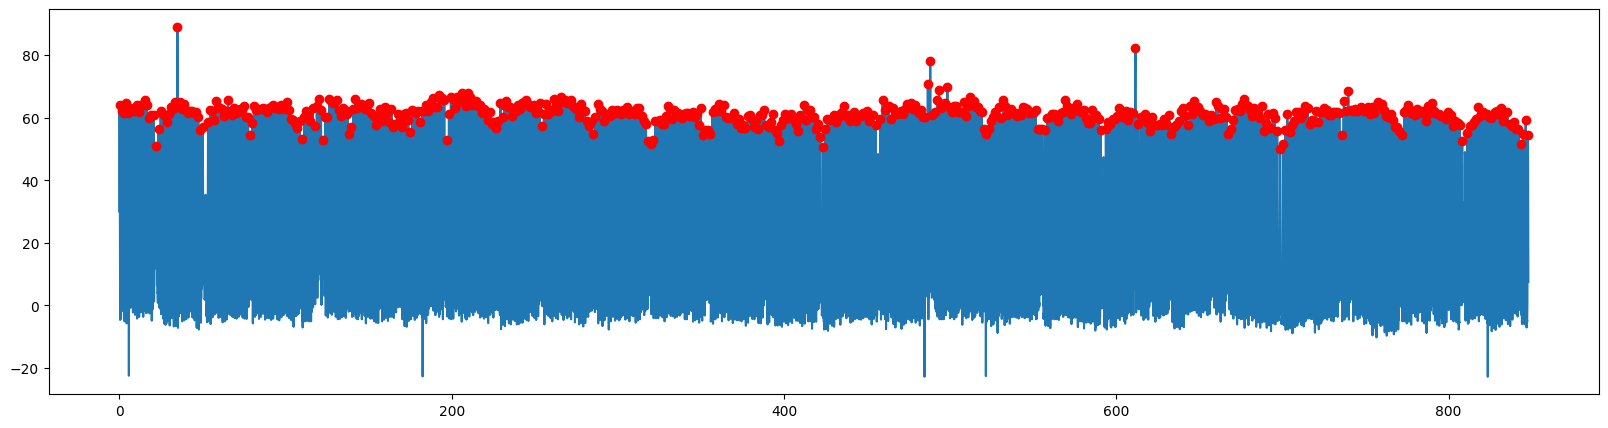

In [6]:
peaks = find_peaks(data_files[0]['Angle'], height=50, distance=125, width=20)
print(peaks[0])
#figura
fig = plt.figure(figsize=(20, 5))
plt.plot(data_files[0]['Elapsed Time'], data_files[0]['Angle'])
plt.plot(peaks[0]/250, data_files[0]['Angle'][peaks[0]], 'ro') 
plt.show()

#### 2.1.2. Visualizar segmentos de la señal de angulo correspondientes a los ciclos de marcha detectados entre las cumbres

Cada segmento se grafica sobre el mismo eje para comparar visualmente los diferentes ciclos de marcha. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


662


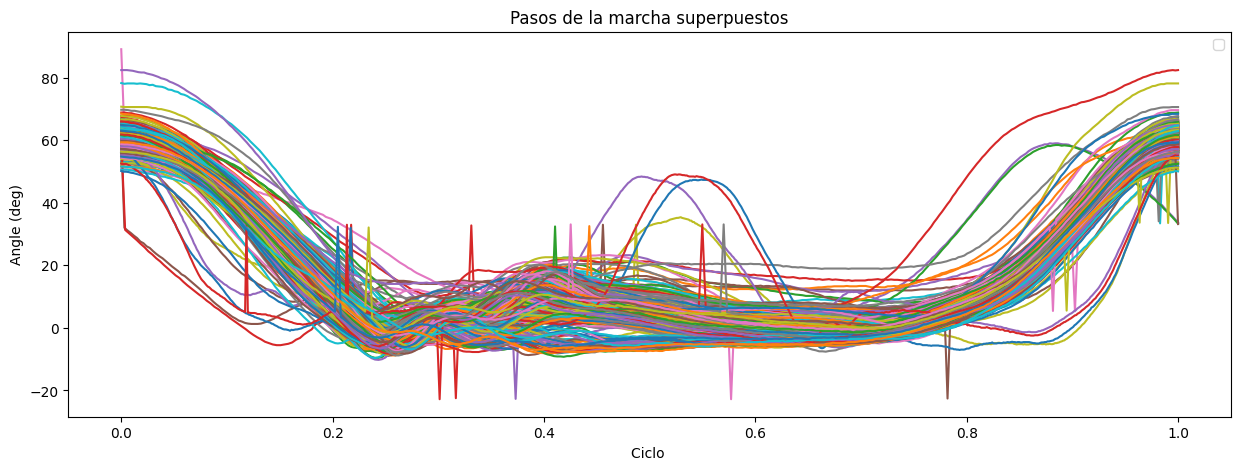

In [7]:
step = [] #almacena segmentos de la señal de angulo

# extrae segmentos de la señal basados en las cumbres
for i in range(1, len(peaks[0])-1):
    step.append(np.array(data_files[0]['Angle'][peaks[0][i]:peaks[0][i+1]]))   

# creacion figura para visualizar
fig = plt.figure(figsize=(15, 5))

#grafico cada segmento de la marcha
for i in range(len(step)):
    t = np.linspace(0, 1, len(step[i]))
    plt.plot(t, step[i])
print(len(step))
plt.xlabel('Ciclo ')
plt.ylabel('Angle (deg)')
plt.legend()
plt.title('Pasos de la marcha superpuestos')
plt.show()

### 2.2. Preparando datos

In [8]:
# Definicion muscles
muscles = data_files[0].columns[1:-1]   #columnas del df de musculos en datos de EMG


# Inicializar listas
step = [] #pasos
emg = []  #ventanas de EMG normalizadas
file = [] #indice del archivo de origen de cada paso

# Itero sobre archivos de datos
for index, data in enumerate(data_files):

    # Deteccion de cumbres en la señal de angulo (altura min, distancia min entre cumbres, ancho min de la cumbre)
    peaks = find_peaks(data['Angle'], height=50, distance=125, width=20)

    # Extraccion y Normalizacion de ventanas de datos
    for i in range(1, len(peaks[0])-1):
        step.append(np.array(data['Angle'][peaks[0][i]:peaks[0][i+1]]))
        emg_window = data[muscles][peaks[0][i]:peaks[0][i+1]].reset_index(drop=True)
        emg_window = np.array(emg_window)

        # normalize
        emg_window = (emg_window - emg_window.mean())/emg_window.std() # asegura media 0 y std 1 de los datos
        emg.append(emg_window) # un paso normalizado de la marcha
        file.append(index) # archivo al que pertenece el paso

# Convertir de file a un array de numpy
file = np.array(file)

### 2.3 Visualizar datos EMG por 4 musculos diferentes

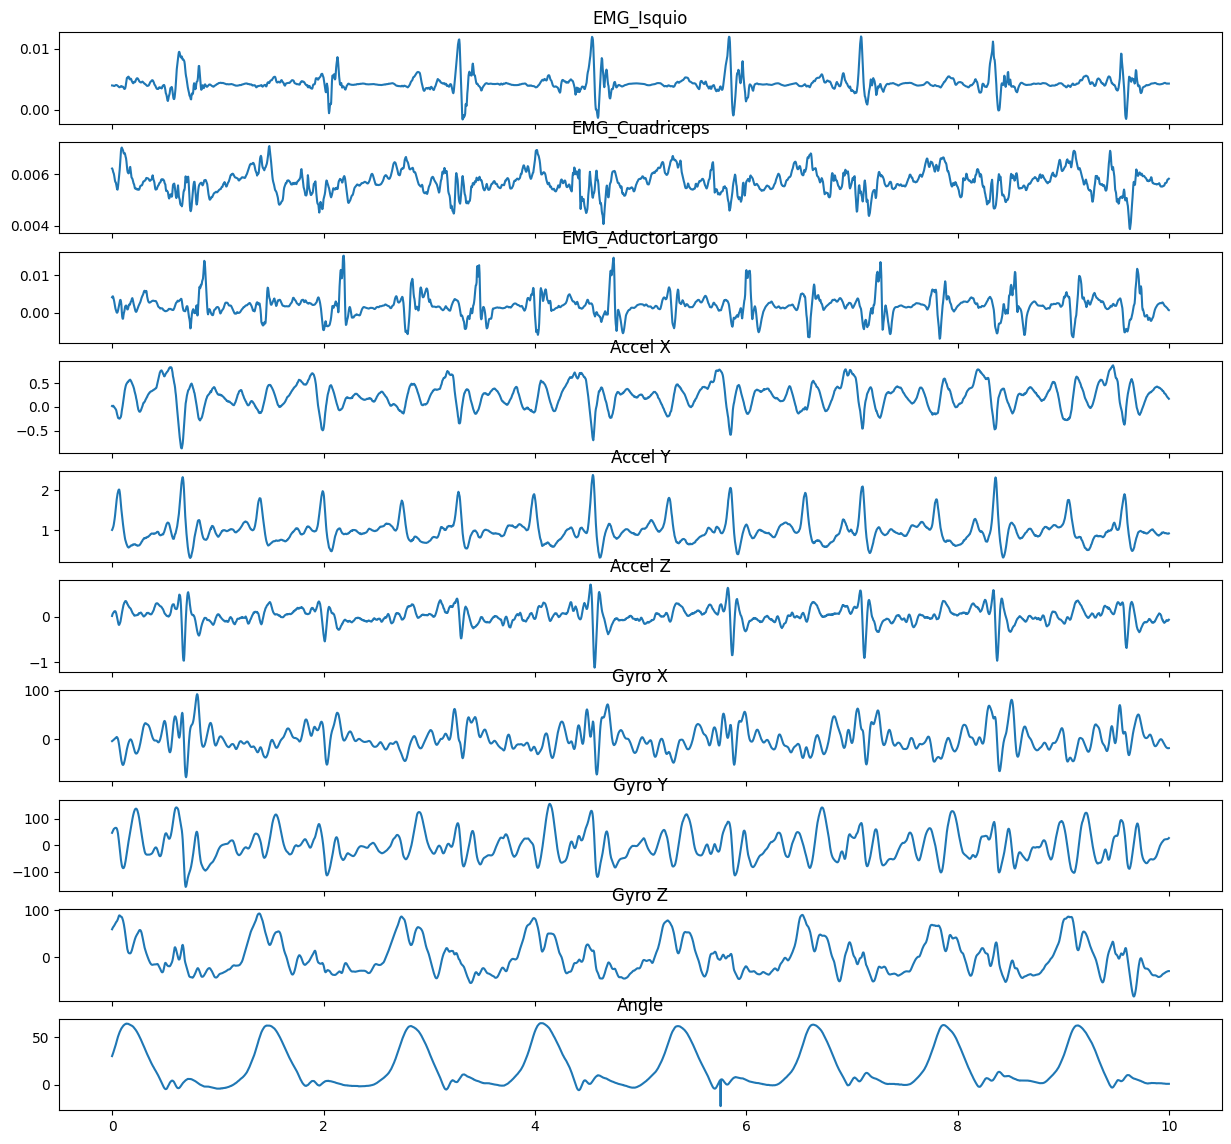

In [9]:
emg_plot(data_files[0])

### 2.4. Define feature extraction function


Caracteristicas Dominio del Tiempo
- **RMS (root mean square):** medida enegia señal - refleja act muscular
- **Varianza:** medidad variabilidad señal - indica cambios en act muscular
- **Kurtosis:** info sobre distribucion datos
- **Skewness:** mide asimetria distribucion señal
- **ZC (zero crossing):** numero de veces que señal cruza el eje cero - indicativo de la frecuencia de disparo de los musculos.

Caracterisicas Dominio de la Frecuencia
- **Espectro de potencia:** distribucion potencia de señal en funcion de frecuencia
- **Mediana de la frecuencia:** frecuencia bajo del cual se encuentra el 50% de la potencia del espectro de la señal
- **Frecuencia Media:** promedio ponderado de las frecuencias presentes en la señal
- **cumbre de Frecuencia:** frecuencia con la mayor potencia en el espectro

Caracteristicas de la Envolvente
- **promedios de la envolvente** 
- **desviacion estandar de la envolvente**
- **maximos de la envolvente**
- **minimos de la envolvente**

Extraer caracteristicas de datos de EMG

In [10]:
#Funcion extraccion caracteristicas
def extract_feature(data, C=[0], divide=3):
    # data : (T, 4) 
    # T numero de muestras, 4 canales de EMG
    # C numero de indices de canales a usar
    # divide: divide la señal en partes iguales

    result = []
    feature_names = []

    for c in C:
        signal0 = data[:, c]

        # Full wave rectification
        rectified_signal = np.abs(signal0)

        #envolvente
        env = np.abs(signal.hilbert(data[:, c]))

        #RMS
        rms = np.sqrt(np.mean(rectified_signal**2))
        result.append(rms)
        feature_names.append(f"rms_channel_{c}")

        #Varianza
        var = np.var(rectified_signal)
        result.append(var)
        feature_names.append(f"var_channel_{c}")

        #kurtosis
        kurt = scipy.stats.kurtosis(rectified_signal)
        result.append(kurt)
        feature_names.append(f"kurt_channel_{c}")

        #skewness
        skew = scipy.stats.skew(rectified_signal)
        result.append(skew)
        feature_names.append(f"skew_channel_{c}")

        #zero crossing
        zc = ((signal0[:-1] * signal0[1:]) < 0).sum()
        result.append(zc)
        feature_names.append(f"zc_channel_{c}")

        #Frecuencias
        freqs, power_spectrum = scipy.signal.welch(signal0, fs=250, nperseg=32)
        median_freq = freqs[np.where(np.cumsum(power_spectrum) >= np.sum(power_spectrum) / 2)[0][0]]
        mean_freq = np.sum(freqs * power_spectrum) / np.sum(power_spectrum)
        peak_freq = freqs[np.argmax(power_spectrum)]

        result.extend([median_freq, mean_freq, peak_freq])
        feature_names.extend([f"median_freq_channel_{c}", f"mean_freq_channel_{c}", f"peak_freq_channel_{c}"])


        #SEGMENTOS
        for i in range(divide):
            start = int(i*len(data)/divide)
            end = int((i+1)*len(data)/divide)

            segment_env = env[start:end]
            mean_env = segment_env.mean()
            std_env = segment_env.std()
            max_env = segment_env.max()
            min_env = segment_env.min()

            result.extend([mean_env, std_env, max_env, min_env])
            feature_names.extend([f"mean_env_segment_{i}_channel_{c}", f"std_env_segment_{i}_channel_{c}",
                                  f"max_env_segment_{i}_channel_{c}", f"min_env_segment_{i}_channel_{c}"])

    result = np.array(result)
    return result, feature_names

In [11]:
# itera sobre datos (division en fases, extrae caract para cada fase, etiquetado)
# conversion a arrays
def label_data_and_features(data, C= [0, 1, 2], divide=3):
    features = []
    labels = []
    feature_names = None

    for e in data:
        T, _ = e.shape
        for i in range(num_fases):
            start = int(i*T/num_fases)
            end = int((i+1)*T/num_fases)
            
            extracted_features, names = extract_feature(e[start:end, :], C=C, divide=divide)
            if feature_names is None:
                feature_names = names
            features.append(extracted_features)
            labels.append(i)

    features = np.array(features)
    labels = np.array(labels)
    return features, labels,feature_names

## 3. Training and testing subsets (definir conjuntos de training y testing)

In [12]:
#Preparacion de datos para entrenamiento y prueba
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [0, 1, 2]  # Canales a utilizar -> Isquio, Cuadriceps y Aductor largo

#Configura params para extraccion de caract
# example_marcha(), contiene 17 archivos, los primeros 16 se usan para entrenar y el último para test
train_data, train_labels, train_feature_names = label_data_and_features(emg[:np.sum(file != 2)], C, divide)
test_data, test_labels,test_feature_names = label_data_and_features(emg[np.sum(file != 2):], C, divide)


In [13]:
print(f"Train data: Extracted {train_data.shape[0]} samples with {train_data.shape[1]} features each.")
print(f"Train labels shape: {train_labels.shape}")
print("-----------------------------------------------------------------------")
print(f"Test data: Extracted {test_data.shape[0]} samples with {test_data.shape[1]} features each.")
print(f"Test labels shape: {test_labels.shape}")
print("-----------------------------------------------------------------------")

# Imprimir nombres de las características extraídas
print("FEATURES NAMES:")
for name in train_feature_names:
    print(name)

Train data: Extracted 5156 samples with 60 features each.
Train labels shape: (5156,)
-----------------------------------------------------------------------
Test data: Extracted 2620 samples with 60 features each.
Test labels shape: (2620,)
-----------------------------------------------------------------------
FEATURES NAMES:
rms_channel_0
var_channel_0
kurt_channel_0
skew_channel_0
zc_channel_0
median_freq_channel_0
mean_freq_channel_0
peak_freq_channel_0
mean_env_segment_0_channel_0
std_env_segment_0_channel_0
max_env_segment_0_channel_0
min_env_segment_0_channel_0
mean_env_segment_1_channel_0
std_env_segment_1_channel_0
max_env_segment_1_channel_0
min_env_segment_1_channel_0
mean_env_segment_2_channel_0
std_env_segment_2_channel_0
max_env_segment_2_channel_0
min_env_segment_2_channel_0
rms_channel_1
var_channel_1
kurt_channel_1
skew_channel_1
zc_channel_1
median_freq_channel_1
mean_freq_channel_1
peak_freq_channel_1
mean_env_segment_0_channel_1
std_env_segment_0_channel_1
max_env_

In [14]:
def clean_normalized_feature_selection(train_data, test_data):
  #Se entrena usando Training y Validation
  sclean       = clean(train_data)      # indices of selected features
  train_data = train_data[:,sclean]   # new training
  test_data  = test_data[:,sclean]    # new testing

  train_data, a, b = minmax(train_data)
  test_data        = test_data * a + b

  return train_data, test_data

In [15]:
train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
print(train_data.shape)
sfs_indices = sfs(train_data, train_labels, 5) # se pide que sean 40 de 40 caracterisitcas
train_data = train_data[:,sfs_indices] # Selecciona las columnas de Xtrain
test_data  =  test_data[:,sfs_indices] # Selecciona las columnas de Xtest
print(sfs_indices)

(5156, 29)
[28 26  8  5 14]


## 4. Classification & Evaluation

 ### Simple NN
 

In [16]:
## 5. Classification

# Definir la estructura de la red neuronal
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hiperparametros
input_size = train_data.shape[1]
hidden_size = 100
output_size = num_fases
learning_rate = 0.001
num_epochs = 100

# Crear el modelo
model = SimpleNN(input_size, hidden_size, output_size)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Preparar los datos para PyTorch
train_tensor = torch.tensor(train_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_tensor = torch.tensor(test_data, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [17]:
## Evaluation

# Entrenamiento de la red neuronal
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluación del modelo en el conjunto de prueba
with torch.no_grad():
    model.eval()
    test_outputs = model(test_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(test_labels_tensor, predicted)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Matriz de confusión
    conf_matrix = confusion_matrix(test_labels_tensor, predicted)
    print(f'Confusion Matrix:\n{conf_matrix}')


Epoch [10/100], Loss: 0.2174
Epoch [20/100], Loss: 0.4992
Epoch [30/100], Loss: 0.0831
Epoch [40/100], Loss: 0.0619
Epoch [50/100], Loss: 0.6574
Epoch [60/100], Loss: 0.0246
Epoch [70/100], Loss: 0.0619
Epoch [80/100], Loss: 0.7354
Epoch [90/100], Loss: 0.0062
Epoch [100/100], Loss: 0.5272
Accuracy: 69.66%
Confusion Matrix:
[[553   4  74  24]
 [ 31 600   2  22]
 [402   3 247   3]
 [ 38 190   2 425]]


### CNN

Shape of train_data: (5156, 5)
Epoch 10/100, Train Loss: 0.37436175539537714, Val Loss: 0.636921688914299
Epoch 20/100, Train Loss: 0.3297185436075116, Val Loss: 0.7381654525311981
Epoch 30/100, Train Loss: 0.31159379089504113, Val Loss: 0.7627685816913117
Epoch 40/100, Train Loss: 0.30490880657309366, Val Loss: 0.7333778182907802
Epoch 50/100, Train Loss: 0.29310375139301204, Val Loss: 0.7413046350929795
Epoch 60/100, Train Loss: 0.29061674386446856, Val Loss: 0.7177012744473248
Epoch 70/100, Train Loss: 0.2849173032115271, Val Loss: 0.744965643599266
Epoch 80/100, Train Loss: 0.278494304942864, Val Loss: 0.719205276450006
Epoch 90/100, Train Loss: 0.27584310961358344, Val Loss: 0.7431194382469829
Epoch 100/100, Train Loss: 0.27471502401210646, Val Loss: 0.7209494669989842
Final Epoch 100/100, Train Loss: 0.27471502401210646, Val Loss: 0.7209494669989842


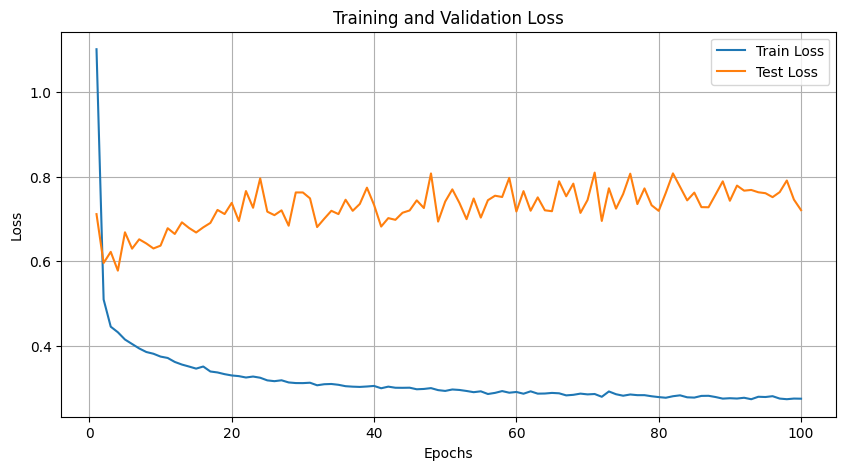

In [18]:
# shape de train_data
print(f'Shape of train_data: {train_data.shape}')

#estructura CNN
class GaitCNN(nn.Module):
    def __init__(self, input_length):
        super(GaitCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        # Calcular el tamaño después de la capa de pooling
        self._to_linear = None
        self.convs(torch.randn(1, 1, input_length))
        self.fc1 = nn.Linear(self._to_linear, 64)
        self.fc2 = nn.Linear(64, num_fases)

    def convs(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self._to_linear is None:
            self._to_linear = x.shape[1] * x.shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Supongamos que train_data tiene la forma (n_samples, sequence_length)
# Añadir una dimensión de canales
train_data_expanded = train_data[:, None, :]  # Añadir dimensión de canales
test_data_expanded = test_data[:, None, :]

# Convertir a tensores
train_data_tensor = torch.tensor(train_data_expanded, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_data_tensor = torch.tensor(test_data_expanded, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Obtener la longitud de la secuencia para inicializar el modelo
input_length = train_data_tensor.shape[2]

# Creación de conjuntos de datos y cargadores de datos
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Entrenamiento del modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = GaitCNN(input_length).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 100

train_loss = []
test_loss = []

# Training the model
for epoch in range(num_epochs):
    cnn_model.train()
    epoch_train_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss.append(loss.item())
    
    train_loss.append(np.mean(epoch_train_loss))
    
    # Validation phase
    cnn_model.eval()
    epoch_test_loss = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)
            
            epoch_test_loss.append(loss.item())
    
    test_loss.append(np.mean(epoch_test_loss))
    
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss[epoch]}, Val Loss: {test_loss[epoch]}')

# Print the final epoch loss
print(f'Final Epoch {num_epochs}/{num_epochs}, Train Loss: {train_loss[-1]}, Val Loss: {test_loss[-1]}')

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Evaluación
cnn_model.eval()
test_outputs = []
test_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = cnn_model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)
        test_predictions.extend(predicted.cpu().detach().numpy())

cnn_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy of CNN: {cnn_accuracy}')

Accuracy of CNN: 0.7053435114503817


### RNN

Shape of train_data: (5156, 5)
Epoch 5/150, Train Loss: 0.5626817925108804, Val Loss: 0.7029938523362322
Epoch 10/150, Train Loss: 0.45847833478524364, Val Loss: 0.7338912835935267
Epoch 15/150, Train Loss: 0.4298721147172245, Val Loss: 0.6748535278730277
Epoch 20/150, Train Loss: 0.415662819220696, Val Loss: 0.7142655549616348
Epoch 25/150, Train Loss: 0.40225660313426714, Val Loss: 0.6591862198419687
Epoch 30/150, Train Loss: 0.3876001446703334, Val Loss: 0.6542058536192266
Epoch 35/150, Train Loss: 0.3692417048653703, Val Loss: 0.6591221890071544
Epoch 40/150, Train Loss: 0.3425719071133637, Val Loss: 0.66092576068349
Epoch 45/150, Train Loss: 0.31384126869616685, Val Loss: 0.6332154799161888
Epoch 50/150, Train Loss: 0.30257378369109866, Val Loss: 0.6857047357210299
Epoch 55/150, Train Loss: 0.2901953822116793, Val Loss: 0.7531057401764684
Epoch 60/150, Train Loss: 0.2819773129382987, Val Loss: 0.7004865847709703
Epoch 65/150, Train Loss: 0.2790506815560806, Val Loss: 0.74431367854

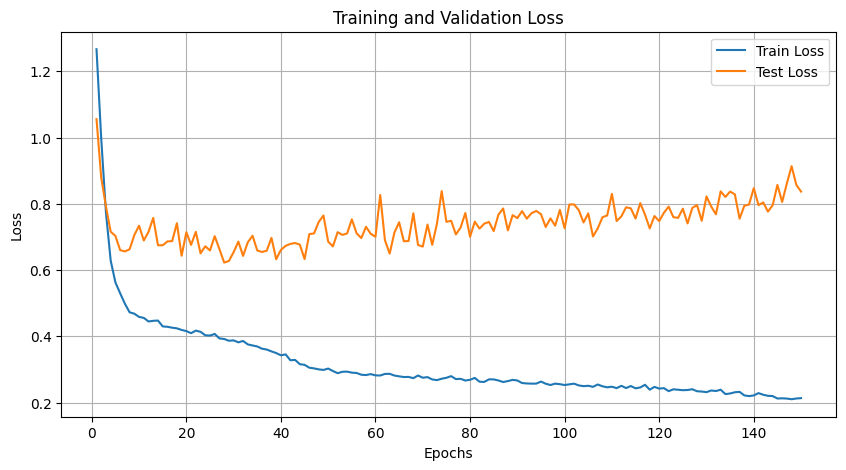

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np

# Verificar la forma de train_data
print(f'Shape of train_data: {train_data.shape}')

# Asegurarse de que train_data tiene tres dimensiones
if len(train_data.shape) == 2:
    train_data = train_data[:, :, np.newaxis]  # Añadir una dimensión extra al final
    test_data = test_data[:, :, np.newaxis]

class GaitRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GaitRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Pasar los datos a través de la LSTM
        out, _ = self.lstm(x)
        
        # Tomar el último tiempo para la salida
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Supongamos que train_data tiene la forma (n_samples, sequence_length, n_features)
input_size = train_data.shape[2]  # Número de características (n_features)
hidden_size = 64
num_layers = 2
num_classes = num_fases

# Convertir a tensores
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Creación de conjuntos de datos y cargadores de datos
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Inicializar el modelo, la función de pérdida y el optimizador
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model = GaitRNN(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)
num_epochs = 150

train_loss = []
test_loss = []

# Training the model
for epoch in range(num_epochs):
    # Training phase
    rnn_model.train()
    epoch_train_loss = []
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = rnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss.append(loss.item())
    
    train_loss.append(np.mean(epoch_train_loss))
    
    # Test phase
    rnn_model.eval()
    epoch_val_loss = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = rnn_model(inputs)
            loss = criterion(outputs, labels)
            
            epoch_val_loss.append(loss.item())
    
    test_loss.append(np.mean(epoch_val_loss))
    
  # Print loss every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss[epoch]}, Val Loss: {test_loss[epoch]}')

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Evaluación del modelo
rnn_model.eval()
test_predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = rnn_model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)
        test_predictions.extend(predicted.cpu().detach().numpy())

rnn_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy of RNN: {rnn_accuracy}')

Accuracy of RNN: 0.7015267175572519
